Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

Setting random seed

In [3]:
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')##set seaborn style

## Define Paths/ Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)

using cuda


In [5]:
pwd

'/content'

Google Drive Mount

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
root_dir = "/content/drive/MyDrive/archive/"
print("The data lies here =>", root_dir)

The data lies here => /content/drive/MyDrive/archive/


Define transforms
* All images to have size (224, 224) as well as convert the images to tensor
* ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
* Channel,Height,Width

In [10]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}

Initialize Datasets

In [11]:
hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]                                     )

In [12]:
hotdog_dataset ##check

Dataset ImageFolder
    Number of datapoints: 498
    Root location: /content/drive/MyDrive/archive/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Mapping of output (ID and class)

In [13]:
hotdog_dataset.class_to_idx  ##returns class ID's present in the dataset

{'hot_dog': 0, 'not_hot_dog': 1}

In [14]:
idx2class = {v: k 
             for k, v in hotdog_dataset.class_to_idx.items()}

In [15]:
idx2class

{0: 'hot_dog', 1: 'not_hot_dog'}

##### First initialize a count_dict dictionary where counts of all classes are initialized to 0.
##### Then, let’s iterate through the dataset and increment the counter by 1 for every class label encountered in the loop.

In [23]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

##### First convert the dictionary to a data-frame.
##### Melt the data frame and plot.

In [16]:
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [17]:
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), 
               plot_title="Entire Dataset (before train/val/test split)")

NameError: ignored

<Figure size 1080x576 with 0 Axes>

In [18]:
hotdog_dataset_size = len(hotdog_dataset)
hotdog_dataset_indices = list(range(hotdog_dataset_size))

In [19]:
np.random.shuffle(hotdog_dataset_indices)

In [20]:
val_split_index = int(np.floor(0.2 * hotdog_dataset_size))

In [21]:
val_split_index

99

In [22]:
train_idx, val_idx = hotdog_dataset_indices[val_split_index:], hotdog_dataset_indices[:val_split_index]

In [23]:
len(train_idx)

399

In [24]:
len(val_idx)

99

In [25]:
## create samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

Load Test data

In [26]:
hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"])
hotdog_dataset_test

Dataset ImageFolder
    Number of datapoints: 500
    Root location: /content/drive/MyDrive/archive/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Train, Validation, and Test Dataloader

-Pass the samplers to our dataloader

*Note that shuffle=True cannot be used when you're using the SubsetRandomSampler.*

In [27]:
train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)

In [28]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

KeyboardInterrupt: ignored

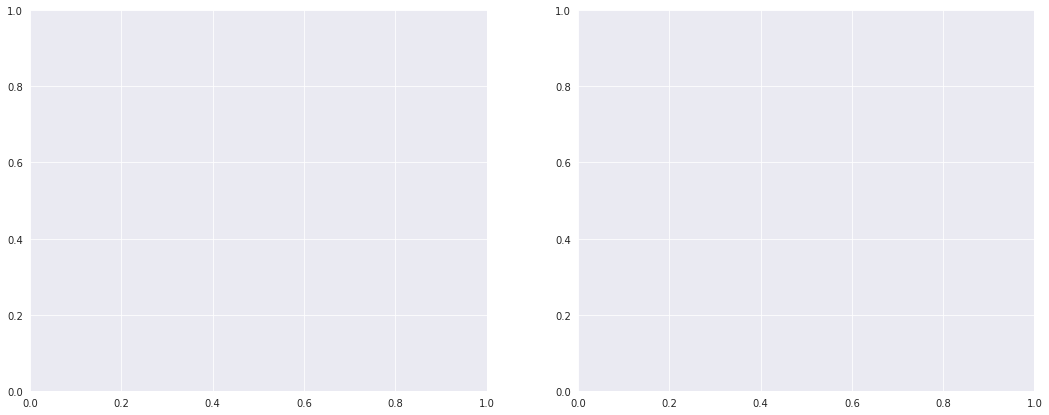

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])

In [30]:
##look at a single image
single_batch = next(iter(train_loader))

In [31]:
single_batch

[tensor([[[[0.1922, 0.1961, 0.2078,  ..., 0.2275, 0.2235, 0.2353],
           [0.1843, 0.1882, 0.2000,  ..., 0.2314, 0.2275, 0.2353],
           [0.1843, 0.1882, 0.2000,  ..., 0.2353, 0.2275, 0.2353],
           ...,
           [0.0235, 0.0275, 0.0314,  ..., 0.2667, 0.2824, 0.2745],
           [0.0314, 0.0353, 0.0471,  ..., 0.2549, 0.2392, 0.2157],
           [0.0392, 0.0471, 0.0627,  ..., 0.2353, 0.2275, 0.2078]],
 
          [[0.1725, 0.1765, 0.1882,  ..., 0.2471, 0.2431, 0.2549],
           [0.1725, 0.1765, 0.1882,  ..., 0.2510, 0.2471, 0.2549],
           [0.1725, 0.1765, 0.1882,  ..., 0.2588, 0.2471, 0.2549],
           ...,
           [0.0078, 0.0118, 0.0157,  ..., 0.2745, 0.2941, 0.2863],
           [0.0118, 0.0157, 0.0275,  ..., 0.2627, 0.2549, 0.2314],
           [0.0196, 0.0275, 0.0431,  ..., 0.2510, 0.2471, 0.2275]],
 
          [[0.1569, 0.1608, 0.1765,  ..., 0.2588, 0.2588, 0.2706],
           [0.1373, 0.1451, 0.1608,  ..., 0.2627, 0.2627, 0.2706],
           [0.1333, 0.13

In [32]:
single_batch[0].shape
## (batch, channels, height, width).

torch.Size([8, 3, 224, 224])

In [33]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([0, 1, 0, 1, 1, 0, 1, 0])

Output label tensor shape:  torch.Size([8])


In [34]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

In [49]:
plt.imshow(single_image.(1, 2, 0))

SyntaxError: ignored

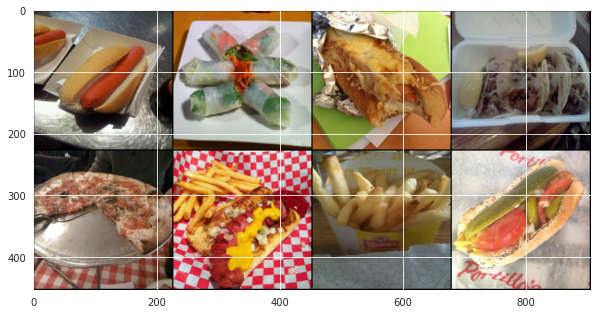

In [38]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

Define a CNN Architecture

-4 blocks of Conv layers. 

-Each block consists of 
Convolution + BatchNorm + ReLU + Dropout layers.

In [41]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [42]:
model = HotDogClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [43]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

####  Define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets

In [44]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [45]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 143.49548 | Val Loss: 132.27969 | Train Acc: 54.280| Val Acc: 52.525
Epoch 02: | Train Loss: 82.16966 | Val Loss: 72.89688 | Train Acc: 61.560| Val Acc: 53.535
Epoch 03: | Train Loss: 38.21023 | Val Loss: 84.72545 | Train Acc: 69.500| Val Acc: 59.596
Epoch 04: | Train Loss: 26.53879 | Val Loss: 49.14476 | Train Acc: 71.180| Val Acc: 55.556
Epoch 05: | Train Loss: 14.22919 | Val Loss: 54.72393 | Train Acc: 81.060| Val Acc: 59.596
Epoch 06: | Train Loss: 9.17638 | Val Loss: 57.05260 | Train Acc: 81.300| Val Acc: 54.545
Epoch 07: | Train Loss: 4.91504 | Val Loss: 31.13350 | Train Acc: 86.800| Val Acc: 57.576
Epoch 08: | Train Loss: 3.59256 | Val Loss: 45.54579 | Train Acc: 88.120| Val Acc: 56.566
Epoch 09: | Train Loss: 3.71305 | Val Loss: 33.46576 | Train Acc: 88.620| Val Acc: 57.576
Epoch 10: | Train Loss: 1.96850 | Val Loss: 33.45828 | Train Acc: 92.700| Val Acc: 59.596
Epoch 11: | Train Loss: 2.09774 | Val Loss: 31.69274 | Train Acc: 92.800| Val Acc: 62.626
Epo

Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

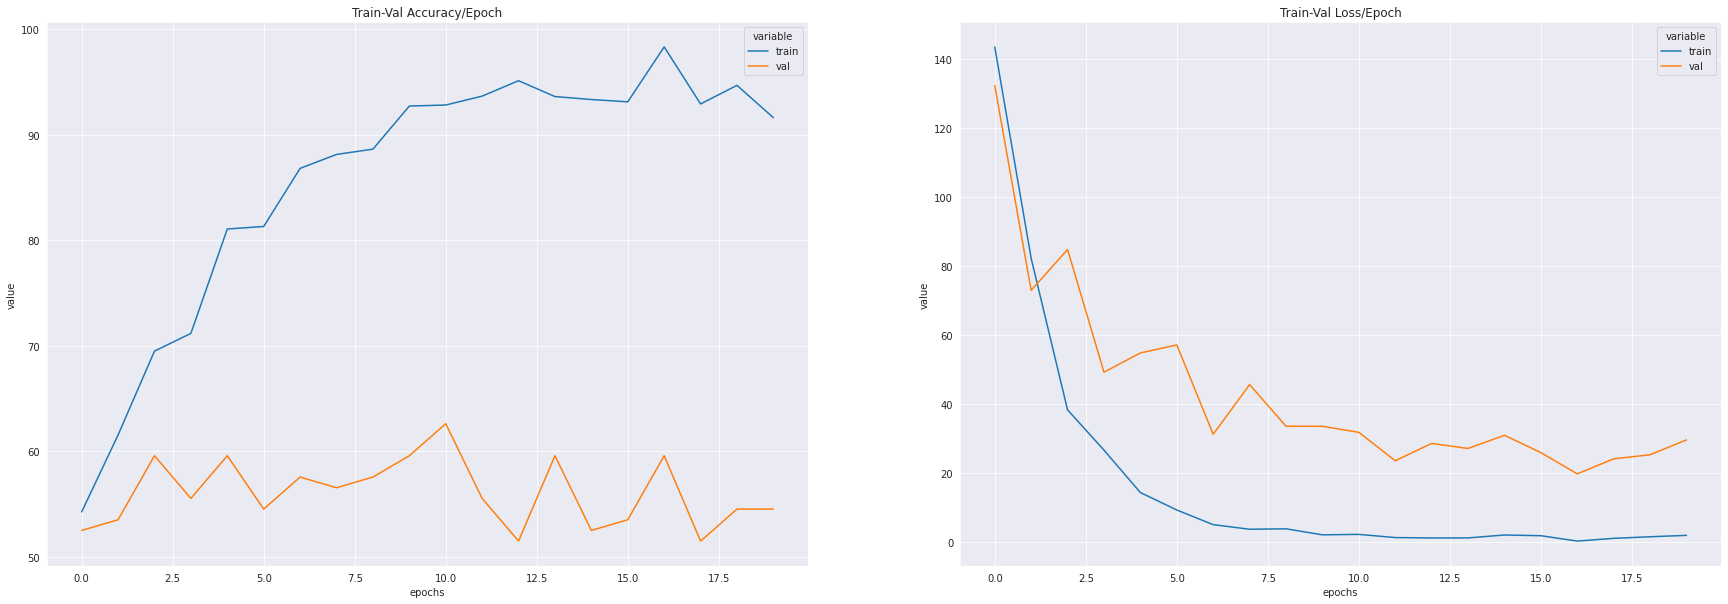

In [46]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Test our model

In [47]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

In [50]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

Classification report

In [51]:
print(classification_report(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.58      0.53      0.55       250
           1       0.57      0.62      0.60       250

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.58       500
weighted avg       0.58      0.58      0.58       500



Confusion matrix

In [52]:
print(confusion_matrix(y_true_list, y_pred_list))

[[132 118]
 [ 94 156]]


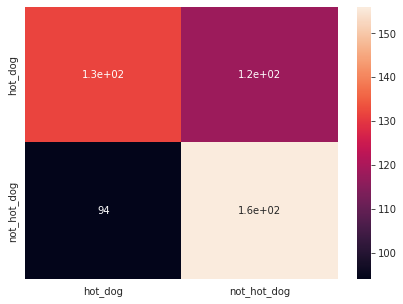

In [53]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

References

https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9